In [1]:
import numpy as np

# Utilities

This notebook contains utility code that is useful to multiple notebooks.

## Derivative Filter

In many control schemes that follow trajectories, higher order derivatives are often needed. This section discusses an implementation of a digital derivative based in Laplace system theory.

Recall from system theory that the Laplace transform is a useful way of analyzing linear time-invariant (LTI) systems. It takes time-domain systems and expresses them in the Laplace domain (a superset of the Fourier frequency domain). The unilateral Laplace transform is defined by
$$
\begin{equation}
F(s) = \int_0^\infty f(t) e^{-st} dt,
\end{equation}
$$
where $t$ is a time variable and $s$ is the Laplace variable. This transform can be thought as projecting a time-domain function onto exponentials of varying phase.

This transform is particularly useful when analyzing LTI systems of differential equations. In particular, the Laplace transform of the time-derivative of a continuous system $f(t)$ can be found to be
$$
\begin{equation}
\frac{d}{dt} f(t) \stackrel{\mathcal{L}}{\rightleftharpoons} sF(s).
\end{equation}
$$

Therefore, differentiation in the time-domain corresponds to multiplication by $s$ in the Laplace domain. Although a pure derivative in the Laplace domain is causal, it is not realizable (i.e., can you build an RLC circuit that realizes $F(s)=s$?). Therefore, a band-limited derivative (i.e., a *dirty derivative*) is used:
$$
\begin{equation}\label{eq:dirty-derivative}
G(s) = \frac{s}{\tau s + 1}.
\end{equation}
$$

From analog filter design, remember that a first-order low-pass filter with cutoff frequency $\omega_c$ is defined in the Laplace domain as
$$
\begin{equation}\label{eq:lpf}
H_{LPF}(s) = \frac{\omega_c}{s + \omega_c} = \frac{1}{s/\omega_c + 1},
\end{equation}
$$
and a first-order high-pass filter is
$$
\begin{equation}\label{eq:hpf}
H_{HPF}(s) = \frac{s}{s + \omega_c} = \frac{s/\omega_c}{s/\omega_c + 1}.
\end{equation}
$$

Note that the cutoff frequency is related to the filter time-constant (and RC circuits) by
$$
\begin{equation}
\tau = RC = \frac{1}{2\pi f_c} = \frac{1}{\omega_c}.
\end{equation}
$$

From this discussion, we can see that the dirty derivative \eqref{eq:dirty-derivative} can be thought of as a filtered version of a pure derivative with bandwidth $1/\tau$. This is useful as the LPF will prevent the derivative operator from picking up high-frequency components of the input signal and amplifying noise.

A common value of $\tau$ is $0.5$ ($20$ Hz). A higher $\tau$ corresponds to less bandwidth and more rejection of high-frequency components, which results in a smoother output.

### Digital Implementation

In order to implement a derivative filter in a computer, it of course must be discretized. The technique used here is to map $G(s)$ to the $z$-domain via the bilinear transform (AKA, Tustin approximation)
$$
\begin{equation}
s \mapsto \frac{2}{T}\frac{1-z^{-1}}{1+z^{-1}} ,
\end{equation}
$$
where $T$ is the sample period. Once we have an expression in the $z$-domain, the inverse $z$-transform can be used to give a discrete-time implementation of the dirty derivative.

#### Resources

- [SE.DSP: First-Derivative Analog Filter](https://dsp.stackexchange.com/questions/41109/first-derivative-analog-filter)
- [Blog: Causal, but not Realizable](http://blog.jafma.net/2015/10/04/differentiation-derivative-is-causal-but-not-exactly-realizable/)

In [2]:
class DirtyDerivative:
    """Dirty Derivative
    
    Provides a first-order derivative of a signal.
    
    This class creates a filtered derivative based on a
    band-limited low-pass filter with transfer function:
    
        G(s) = s/(tau*s + 1)
        
    This is done because a pure differentiator (D(s) = s)
    is not realizable.    
    """
    def __init__(self, order=1, tau=0.05):
        # time constant of dirty-derivative filter.
        # Higher leads to increased smoothing.
        self.tau = tau
        
        # Although this class only provides a first-order
        # derivative, we use this parameter to know how
        # many measurements to ignore so that the incoming
        # data is smooth and stable. Otherwise, the filter
        # would be hit with a step function, causing
        # downstream dirty derivatives to be hit with very
        # large step functions.
        self.order = order
        
        # internal memory for lagged signal value
        self.x_d1 = None
        
        # Current value of derivative
        self.dxdt = None
        
    def update(self, x, Ts):
        # Make sure to store the first `order` measurements,
        # but don't use them until we have seen enough
        # measurements to produce a stable output
        if self.order > 0:
            self.order -= 1
            self.x_d1 = x
            return np.zeros(x.shape)        
        
        # Calculate digital derivative constants
        a1 = (2*self.tau - Ts)/(2*self.tau + Ts)
        a2 = 2/(2*self.tau + Ts)
        
        if self.dxdt is None:
            self.dxdt = np.zeros(x.shape)
        
        # calculate derivative
        self.dxdt = a1*self.dxdt + a2*(x - self.x_d1)
        
        # store value for next time
        self.x_d1 = x
                
        return self.dxdt

---

## Rotation Matrices

Throughout this notebook, we use *right-handed*, *passive* rotations to express the same geometrical vector in various coordinate frames. When Euler angles are used, the *intrinsic* 3-2-1 (Z-Y-X) sequence is used. This means that a yaw ($\psi$) rotation is first performed in $\mathcal{F}_A$ around the $\mathbf{k}^A$ axis to get to $\mathcal{F}_B$. Then, a pitch ($\theta$) rotation is performed about the $\mathbf{j}^B$ axis of frame B to get to $\mathcal{F}_C$. Lastly, a roll ($\phi$) rotation is performed about the $\mathbf{i}^C$ axis to get to $\mathcal{F}_D$. The order of rotation is important, and if data from $\mathcal{F}_A$ is meant to be expressed in $\mathcal{F}_D$, the rotations are composed as
$$
\begin{equation}
x^D = R_C^D(\phi) R_B^C(\theta) R_A^B(\psi)x^A = R_A^D(\phi,\theta,\psi)x^A = R_A^D x^A.
\end{equation}
$$

Python implementations of these passive rotations are defined below.

In [3]:
# input angle in radians
def rotx(ph): return np.array([[1,0,0],[0,np.cos(ph),np.sin(ph)],[0,-np.sin(ph),np.cos(ph)]])
def roty(th): return np.array([[np.cos(th),0,-np.sin(th)],[0,1,0],[np.sin(th),0,np.cos(th)]])
def rotz(ps): return np.array([[np.cos(ps),np.sin(ps),0],[-np.sin(ps),np.cos(ps),0],[0,0,1]])
def rot3(ph,th,ps): return rotx(ph).dot(roty(th).dot(rotz(ps)))
# input angle in degrees
def rotxd(ph): return rotx(np.radians(ph))
def rotyd(th): return roty(np.radians(th))
def rotzd(ps): return rotz(np.radians(ps))
def rot3d(ph,th,ps): return rot3(np.radians(ph),np.radians(th),np.radians(ps))

---

## PID Controller

One of the simplest forms of feedback control is the proportional-integral-derivative (PID) controller. It is perhaps the most widely used form of control because it is an intuitive technique for minimizing error. However, stability can only be guaranteed for second-order systems.

### Digital Implementation

In order to implement a PID controller on a computer, we need to discretize our continuous expression for the integral and derivative terms of the PID controller.

In [4]:
class SimplePID:
    def __init__(self, kp, ki, kd, min, max, tau=0.05):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.min = min
        self.max = max
        self.tau = tau

        self.derivative = 0.0
        self.integral = 0.0

        self.last_error = 0.0
        
    @staticmethod
    def _clamp(v, limit):
        return v if np.abs(v) < limit else limit*np.sign(v)

    def run(self, error, dt, derivative=None, pclamp=None):

        # P term
        if self.kp:
            # Proportional error clamp, it specified
            e = error if pclamp is None else self._clamp(error, pclamp)
            p_term = self.kp * e
        else:
            p_term = 0.0

        # D term
        if self.kd:
            if derivative:
                self.derivative = derivative
            elif dt > 0.0001:
                self.derivative = (2.0*self.tau - dt)/(2.0*self.tau + dt)*self.derivative + 2.0/(2.0*self.tau + dt)*(error - self.last_error)
            else:
                self.derivative = 0.0
            d_term = self.kd * self.derivative
        else:
            d_term = 0.0

        # I term
        if self.ki:
            self.integral += (dt/2.0) * (error + self.last_error)
            i_term = self.ki * self.integral
        else:
            i_term = 0.0

        # combine
        u = p_term + d_term + i_term

        # saturate
        if u < self.min:
            u_sat = self.min
        elif u > self.max:
            u_sat = self.max
        else:
            u_sat = u

        # integrator anti-windup
        if self.ki:
            if abs(p_term + d_term) > abs(u_sat):
                # PD is already saturating, so set integrator to 0 but don't let it run backwards
                self.integral = 0
            else:
                # otherwise only let integral term at most take us just up to saturation
                self.integral = (u_sat - p_term - d_term) / self.ki

        # bookkeeping
        self.last_error = error

        return u_sat

---

## Numerical Integration

Before our discussion of the dynamical equations of motion that describe the time evolution of the quadrotor in $\text{SE}(3)$, we should discuss how to properly integrate these differential equations numerically for use in a simulation. The two most common types of numerical integrators are Euler's method and the fourth order Runge-Kutta method, or RK4.

### The Euler Method

The Euler method is an explicit algorithm that uses the limit definition of the derivative:
$$
\frac{df}{dt} = \lim_{h\to0} \frac{f(t + h) - f(t)}{h}.
$$
Let $g(t) \triangleq \frac{df}{dt}(t)$. Disregarding the limit and rearranging the difference quotient yields
$$
f(t+h) = f(t) + g(t)h.
$$
Using the step size $h$ as the sample period and using discrete notation, we have
$$
f[k+1] = f[k] + g[k] T_s.
$$

### RK4

Of course, the Euler Method is a first-order, rough approximation of differential equations. Given a differential equation $\dot{y} = f(t,y)$, the RK4 method is given by
$$
\begin{align}
y_{n+1}	&=	y_{n}+\frac{h}{6}\left(k_{1}+2k_{2}+2k_{3}+k4\right) \\
t_{n+1}	&=	t_{n}+h,
 \end{align}
$$

where
$$
\begin{align}
k_{1} &= f\left(t_{n},y_{n}\right) \\
k_{2} &= f\left(t_{n}+\frac{h}{2},y_{n}+\frac{h}{2}k_{1}\right) \\
k_{3} &= f\left(t_{n}+\frac{h}{2},y_{n}+\frac{h}{2}k_{2}\right) \\
k_{4} &= f\left(t_{n}+h,y_{n}+hk_{3}\right).
\end{align}
$$

For an expository derivation of RK4, see [2].

In [5]:
def rk4(f, y, dt):
    """Runge-Kutta 4th Order
    
    Solves an autonomous (time-invariant) differential equation of the form dy/dt = f(y).
    """
    k1 = f(y)
    k2 = f(y + dt/2*k1)
    k3 = f(y + dt/2*k2)
    k4 = f(y + dt  *k3)
    return y + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)

#### RK4 Example

Consider the autonomous evolution of position $x \in \mathbb{R}$ as
$$
\dot{x} = \cos(\omega(t))
$$

where
$$
\omega(t) =
\begin{cases}
    2 \pi t, & 0 < t < 2.5 \\
    4 \pi t, & 2.5 \leq t < 5 \\
\end{cases}.
$$

Note that this equation is not smooth (there is a jump at $t = 2.5$), but we are still able to numerically integrate it.

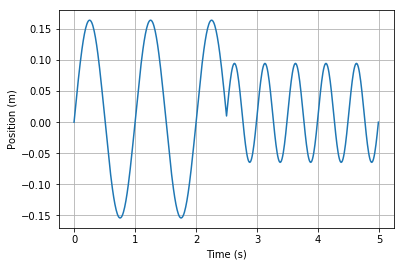

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# simulation timing
Tf = 5
Ts = 0.01
N = int(Tf/Ts)

# initital condition
x = 0

# simulation history
x_hist = np.zeros((N,1))

for i in range(N-1):
    # dynamics
    freq = 1 if i < N//2 else 2
    v = np.cos(2*np.pi*freq*(Ts*i))
    f = lambda x: v

    # propagate dynamics by solving the differential equation
    x = rk4(f, x, Ts)
    
    # add to history
    x_hist[i+1] = x
    
plt.plot(np.arange(0, Tf, Ts), x_hist)
plt.grid(); plt.xlabel('Time (s)'); plt.ylabel('Position (m)')
plt.show()

### Lie Group Integration

Note that the above formulations we assume Euclidean spaces instead of matrix Lie groups.

---